# Spirals dataset

In this notebook, you will generate artificial data yourself, teach a classification model on them and measure its final quality.

In the course of code execution, there will be places that require your improvement. These sections will be marked with comments

\#\#\# YOUR CODE HERE \#\#\#

...

\#\#\# YOUR CODE HERE \#\#\#

Inside this section, you will have to add the code so as to perform the required operations.

# Preparation

Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Setting the style for graphs

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix a random number generator for reproducibility of the experiment

In [3]:
np.random.seed(21)
torch.manual_seed(21);

# Artificial data generation

Artificial data is used in machine learning in several cases:

* **Training tasks (our case)**
* Expansion of the existing sample of real data
* Correction of the imbalance in the number of objects in different classes (data upsampling)
* ...

Here we will generate 2D geometric data in the form of a spiral. The spiral will have several petals, each of which will belong to a separate class.

Total:

* Each object of our data has **2 attributes**, which we interpret as coordinates on the plane
* We want to predict which of the **3 classes** the object belongs to

In [60]:
n_features = 2   # number of features 
n_classes = 4    # number of classes

The function for generating the data described above is implemented below

In [61]:
def get_data(n_samples=100, n_classes=3, random_state=None):
    """
    Generate 2D spiral data

    Args:
        n_samples(int): number of samples per class
        n_classes(int): number of classes
        random_state(int): random state to fix

    Return:
        X(ndarray): array of points
        y(ndarray): labels
    """
    if random_state is not None:
        np.random.seed(random_state)

    X = np.zeros((n_samples * n_classes, 2))
    y = np.zeros(n_samples * n_classes, dtype='uint8')

    for j in range(n_classes):
        ix = range(n_samples * j, n_samples * (j + 1))
        r = np.linspace(0.0, 1, n_samples) # radius
        t = np.linspace(j * 4, (j + 1) * 4, n_samples) + np.random.randn(n_samples) * 0.2 # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j

    return X, y

To properly train the model, we want to have a validation sample. In the case of real data, a train-test split is usually done and a small subset of data is separated for validation.

In our case, since we generate the data ourselves, we can separately generate training and validation data.

In [62]:
X_train, y_train = get_data(n_samples=100, n_classes=n_classes, random_state=21)
X_valid, y_valid = get_data(n_samples=50, n_classes=n_classes, random_state=12)

Now let's depict our data

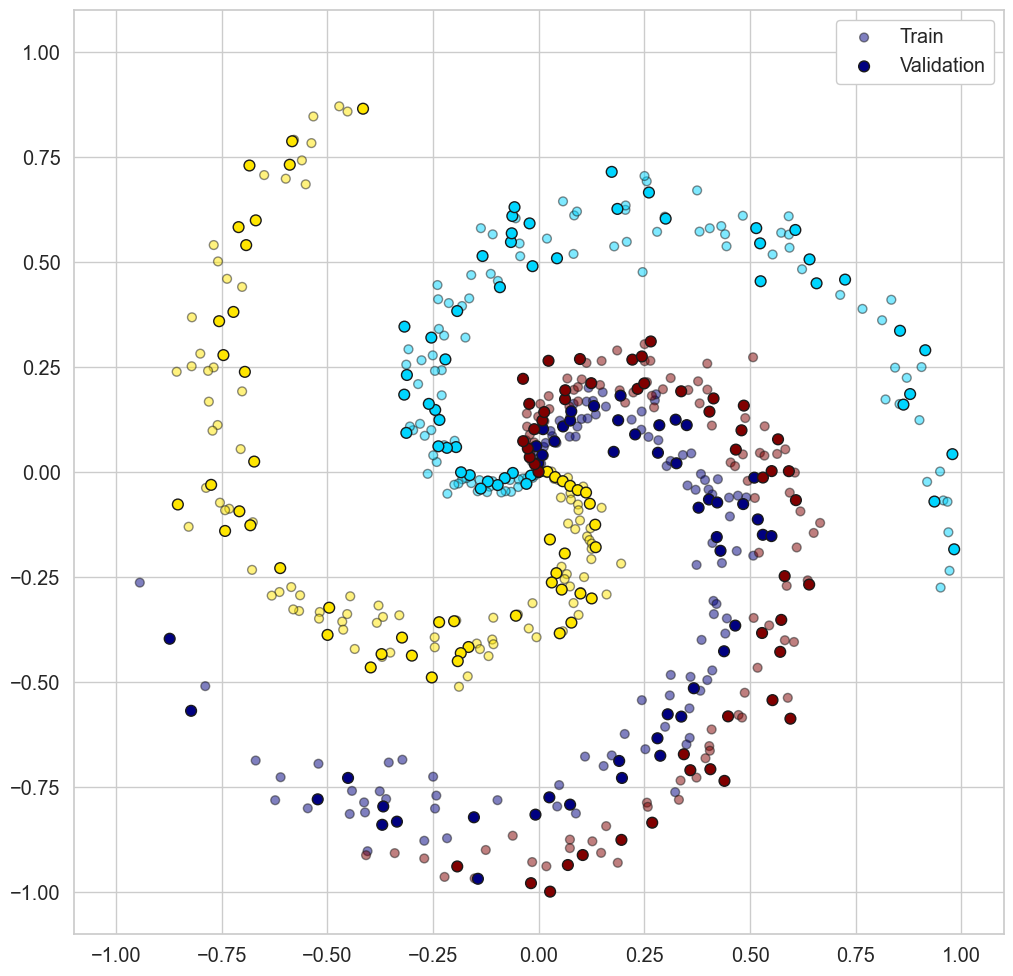

In [63]:
plt.figure(figsize=(12, 12))
plt.scatter(X_train[:, 0], X_train[:, 1], s=40,
            c=y_train, cmap="jet", edgecolors="k", alpha=0.5,
            label="Train")
plt.scatter(X_valid[:, 0], X_valid[:, 1], s=60,
            c=y_valid, cmap="jet", edgecolors="k",
            label="Validation")
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.legend();

# Models

## Baseline: Sklearn Logistic Regression

In order to have a quality value, from which you can start further in comparing models, it is customary to first make the simplest basic model. It is called the baseline. Here, as a baseline, we will take a linear classification model from the Sklearn library.

Note that although the model is called **logistic regression**, it solves the problem of **classification**. There is no mistake here.

In [64]:
model_lr_sklearn = LogisticRegression(C = 1e8,
                                      max_iter=200,
                                      solver="sag",
                                      multi_class="multinomial")

Training model

In [65]:
model_lr_sklearn.fit(X_train, y_train)

LogisticRegression(C=100000000.0, max_iter=200, multi_class='multinomial',
                   solver='sag')

Evaluating quality

In [66]:
print("Train accuracy: {:.1f}%".format(model_lr_sklearn.score(X_train, y_train) * 100))
print("Valid accuracy: {:.1f}%".format(model_lr_sklearn.score(X_valid, y_valid) * 100))

Train accuracy: 37.8%
Valid accuracy: 39.0%


Draw the resulting separating surface

In [67]:
def plot_model(model, X, y, val_data=None):
    # get limits
    x_min, x_max = X[:, 0].min() * 1.1, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 1.1, X[:, 1].max() * 1.1
    # generate mesh grid
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # get model predictions
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # plot
    plt.figure(figsize=(12, 12))
    plt.contourf(xx, yy, Z, cmap="jet", alpha=0.1)
    if val_data is not None:
        X_valid, y_valid = val_data
        plt.scatter(X[:, 0], X[:, 1], s=40,
                    c=y, cmap="jet", edgecolors="k", alpha=0.5,
                    label="Train")
        plt.scatter(X_valid[:, 0], X_valid[:, 1], s=60,
                    c=y_valid, cmap="jet", edgecolors="k", alpha=1.0,
                    label="Validation")
    else:
        plt.scatter(X[:, 0], X[:, 1], s=40,
                    c=y, cmap="jet", edgecolors="k", alpha=1.0,
                    label="Train")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()

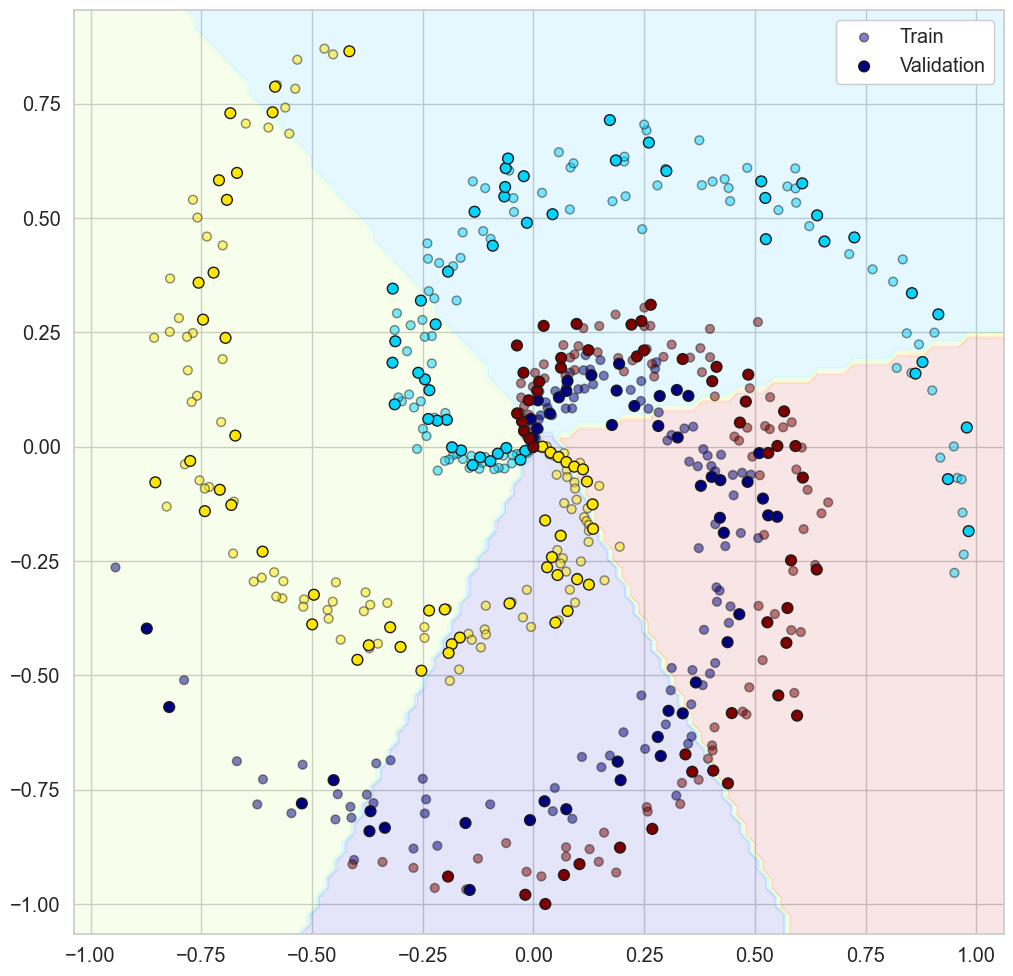

In [68]:
plot_model(model_lr_sklearn, X_train, y_train, (X_valid, y_valid))

The linear classifier, as expected, does not work very well here.

## PyTorch

PyTorch requires its own type of vectors, which is called tensor and is slightly different from the format in Numpy

In [69]:
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float)
X_valid_tensor = torch.tensor(np.array(X_valid), dtype=torch.float)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

We will also define the basic constants from the data to use them in the future

In [70]:
n_data = len(X_train_tensor)
n_data

400

In [71]:
n_features

2

In [72]:
n_classes

4

We will evaluate our model by two metrics:
* CCE (Categorical Cross Entropy)
* Accuracy

In [73]:
def accuracy_loss(input, target):
    return torch.mean((np.argmax(input, axis=1) == target).type(torch.float)) * 100

We will also define the error function according to which we will train the model. In our case, this is CCE.

In [74]:
loss_func = nn.CrossEntropyLoss()

Let's set a set of metrics that we want to track

In [75]:
metrics_func = [loss_func, accuracy_loss]
metrics_name = ["CCE", "Accuracy"]

Let's define a function for evaluating the quality of one model on a given dataset by given metrics

In [76]:
def evaluate(model, metrics_func, X, y):
    metrics_value = []
    with torch.no_grad():
        preds = model(X)
        for metric_func in metrics_func:
            metric_value = metric_func(preds, y)
            metrics_value.append(metric_value)
    return metrics_value

Utility for visualizing the separating surface for PyTorch models

In [77]:
def plot_model_pytorch(model, X, y, val_data=None):

    class ModelClfPredictor(object):

        def __init__(self, model_clf_pytorch):
            self._model = model_clf_pytorch

        def predict(self, X):
            with torch.no_grad():
                preds = self._model(torch.FloatTensor(X))
            return np.argmax(np.array(preds), axis=1)

    _temp = ModelClfPredictor(model)
    plot_model(_temp, X, y, val_data)

### Logistic regression

The Logistic Regression model can be considered as a simple neural network without hidden layers and without activation functions.

The number of features in our Spirals dataset is 2. Therefore, the input layer has 2 neurons. We want to predict the number of the class to which the object belongs. We have 3 classes in total. Therefore, there will be 3 output neurons - each neuron shows the probability of belonging to each of the classes. As a result, the object will belong to the class whose probability is greater.

In [78]:
model_lr = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=n_classes),
)

For training, we will use the simplest gradient method of step-by-step optimization - Batch Gradient Descent.

In [79]:
opt_lr = optim.SGD(params=model_lr.parameters(), lr=0.01)
batch_size_lr = 16

Training model

In [80]:
%%time

epochs_lr = 1500
history_lr_train = []
history_lr_valid = []

for epoch in tqdm(range(epochs_lr)):
    for i in range((n_data - 1) // batch_size_lr + 1):

        # forming data batches
        start_i = i * batch_size_lr
        end_i = start_i + batch_size_lr
        Xb = X_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]

        # forward pass: making predictions
        pred = model_lr(Xb)
        # forward pass: calculate loss
        loss = loss_func(pred, yb)

        # backward pass: calculate gradients
        loss.backward()

        # weights update
        opt_lr.step()
        opt_lr.zero_grad()

    history_lr_train.append(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor))
    history_lr_valid.append(evaluate(model_lr, metrics_func, X_valid_tensor, y_valid_tensor))

history_lr_train = np.array(history_lr_train)
history_lr_valid = np.array(history_lr_valid)

  0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 3.87 s, sys: 1.07 s, total: 4.94 s
Wall time: 4.68 s


Let's draw how the error function changed in the course of training

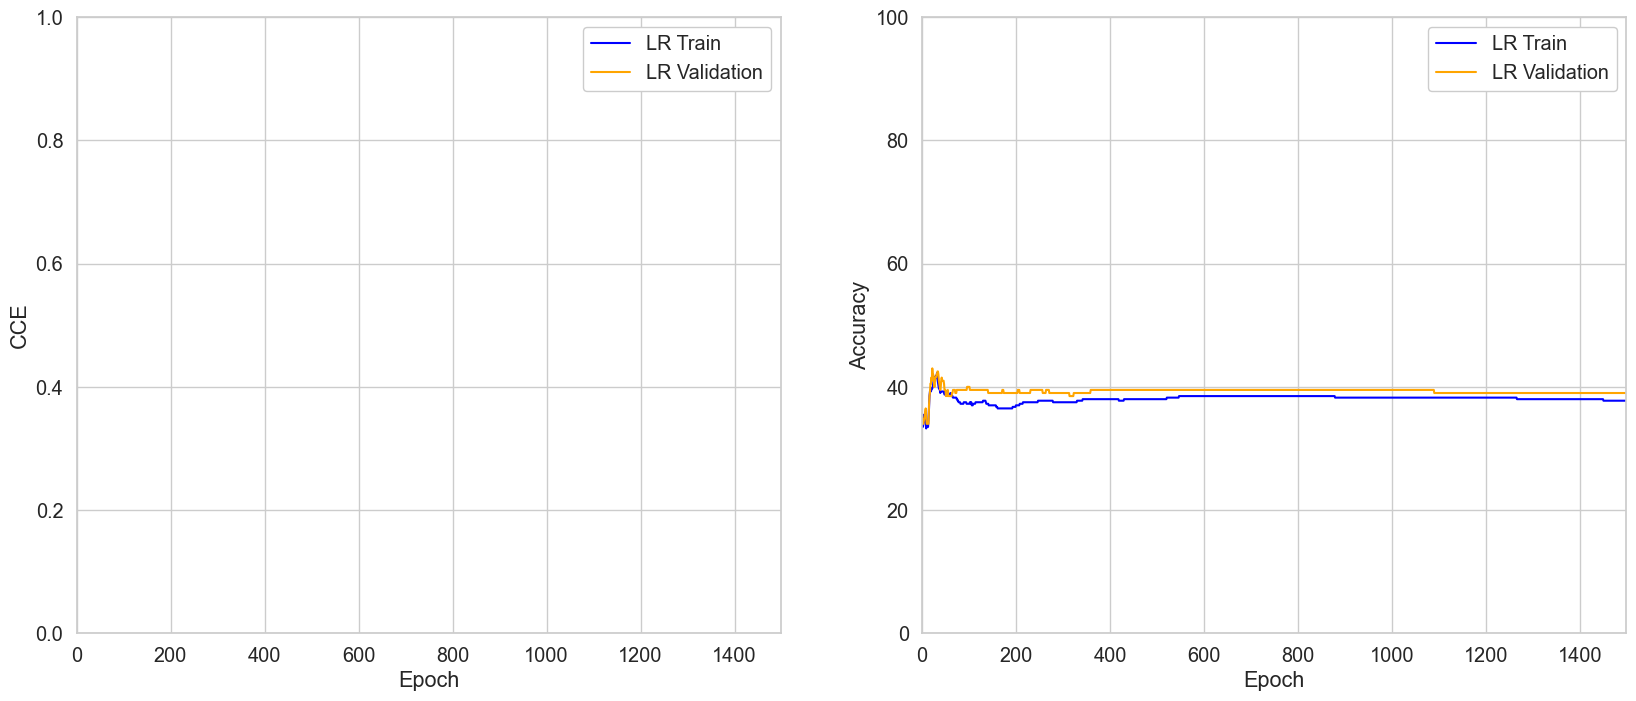

In [81]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 0], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 1])
plt.xlim([0, epochs_lr - 1])
plt.ylabel("CCE")
plt.xlabel("Epoch");

plt.subplot(122)
plt.plot(history_lr_train[:, 1], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 1], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 100])
plt.xlim([0, epochs_lr - 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

Draw the resulting separating surface

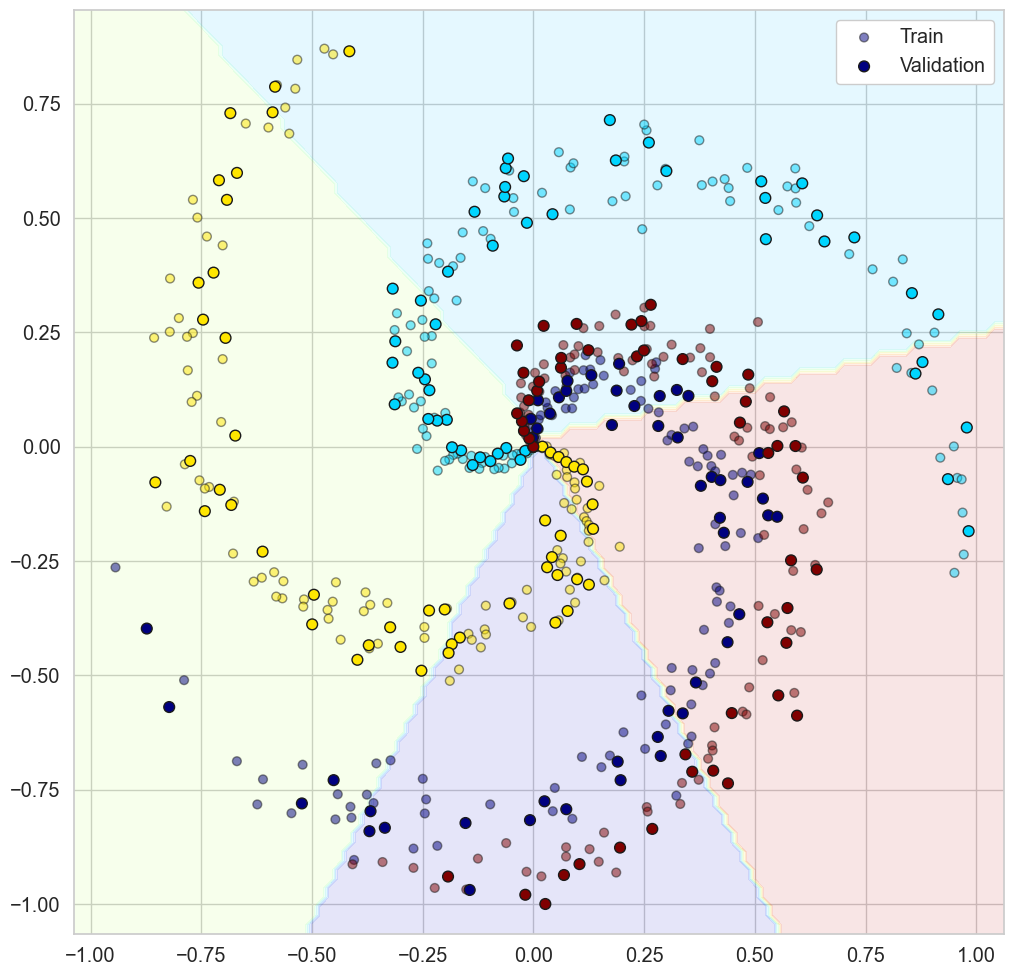

In [82]:
plot_model_pytorch(model_lr, X_train, y_train, (X_valid, y_valid))

Final metrics

In [83]:
print("Train accuracy: {:.1f}%".format(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor)[1].item()))
print("Valid accuracy: {:.1f}%".format(evaluate(model_lr, metrics_func, X_valid_tensor, y_valid_tensor)[1].item()))

Train accuracy: 37.8%
Valid accuracy: 39.0%


### Task: MLP with 3 hidden layers

Now we define a more complex model with 3 hidden layers and a ReLU activation function.

![relu image](https://analyticsindiamag.com/wp-content/uploads/2018/01/relu-activation-function-1.png)

Your task is to create a neural network with the following architecture

* The first hidden layer is 16 neurons
* Activation function - ReLU
* The second hidden layer - 32 neurons
* Activation function - ReLU
* The third hidden layer - 32 neurons
* Activation function - ReLU

(For example, you can look at the laptop from the practical part of the task)

In [84]:
### YOUR CODE HERE ###
model_mlp_3 = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=n_classes)
)
### YOUR CODE HERE ###

The training setting is the same as before.

In [85]:
opt_mlp_3 = optim.SGD(params=model_mlp_3.parameters(), lr=0.01)
batch_size_mlp_3 = 16

Training model

In [86]:
%%time

epochs_mlp_3 = 1500
history_mlp_3_train = []
history_mlp_3_valid = []

for epoch in tqdm(range(epochs_mlp_3)):
    for i in range((n_data - 1) // batch_size_mlp_3 + 1):

        # forming data batches
        start_i = i * batch_size_mlp_3
        end_i = start_i + batch_size_mlp_3
        Xb = X_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]

        # forward pass: making predictions
        pred = model_mlp_3(Xb)
        # forward pass: calculate loss
        loss = loss_func(pred, yb)

        # backward pass: calculate gradients
        loss.backward()

        # weights update
        opt_mlp_3.step()
        opt_mlp_3.zero_grad()

    history_mlp_3_train.append(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor))
    history_mlp_3_valid.append(evaluate(model_mlp_3, metrics_func, X_valid_tensor, y_valid_tensor))

history_mlp_3_train = np.array(history_mlp_3_train)
history_mlp_3_valid = np.array(history_mlp_3_valid)

  0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 8.4 s, sys: 1.18 s, total: 9.58 s
Wall time: 9.03 s


Let's draw how the error function changed during training and compare it with the previous model (PyTorch Logistic Regression)

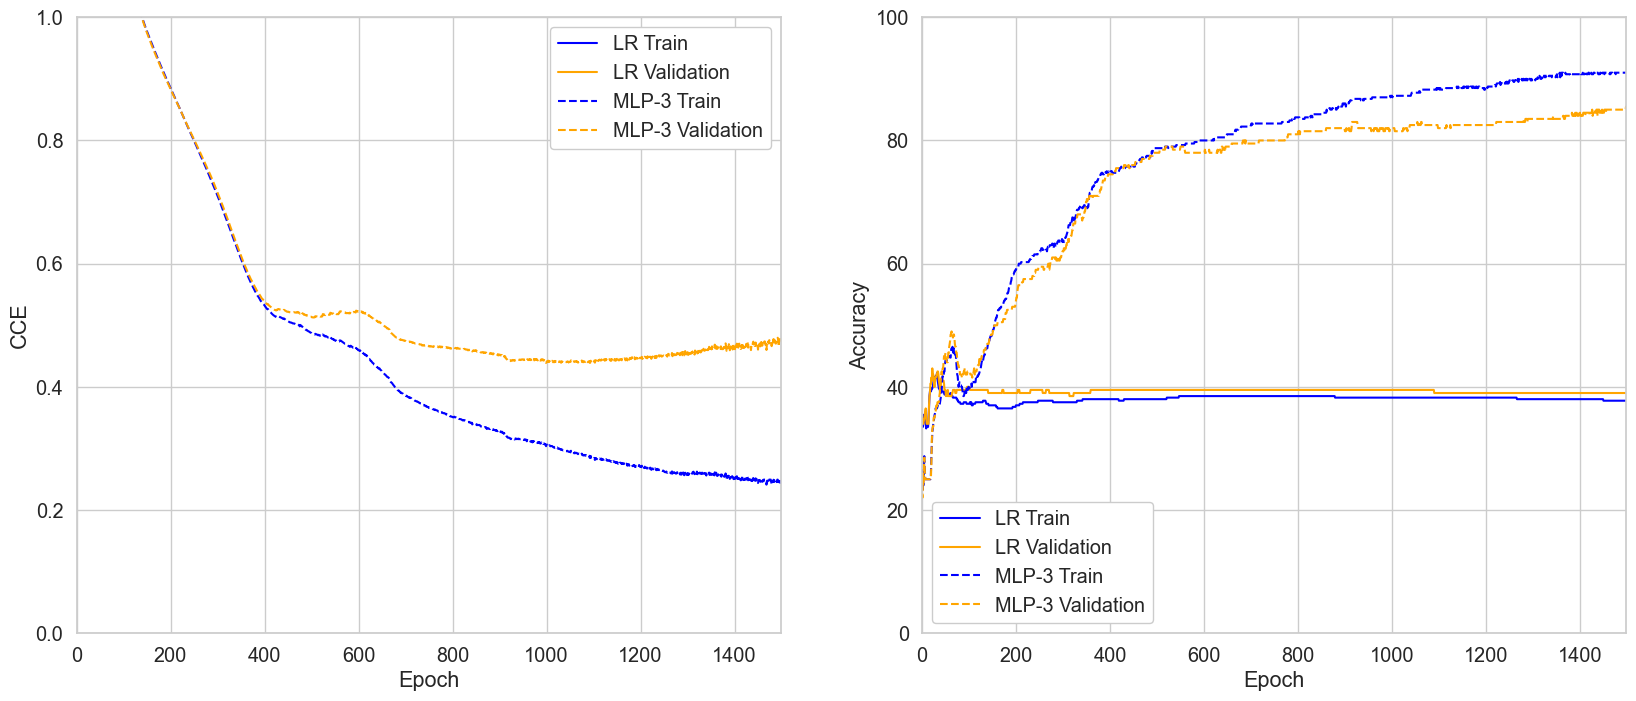

In [87]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 0], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 0], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_valid[:, 0], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 1])
plt.xlim([0, epochs_mlp_3 - 1])
plt.ylabel("CCE")
plt.xlabel("Epoch");

plt.subplot(122)
plt.plot(history_lr_train[:, 1], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 1], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 1], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_valid[:, 1], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 100])
plt.xlim([0, epochs_mlp_3 - 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

Draw the resulting separating surface

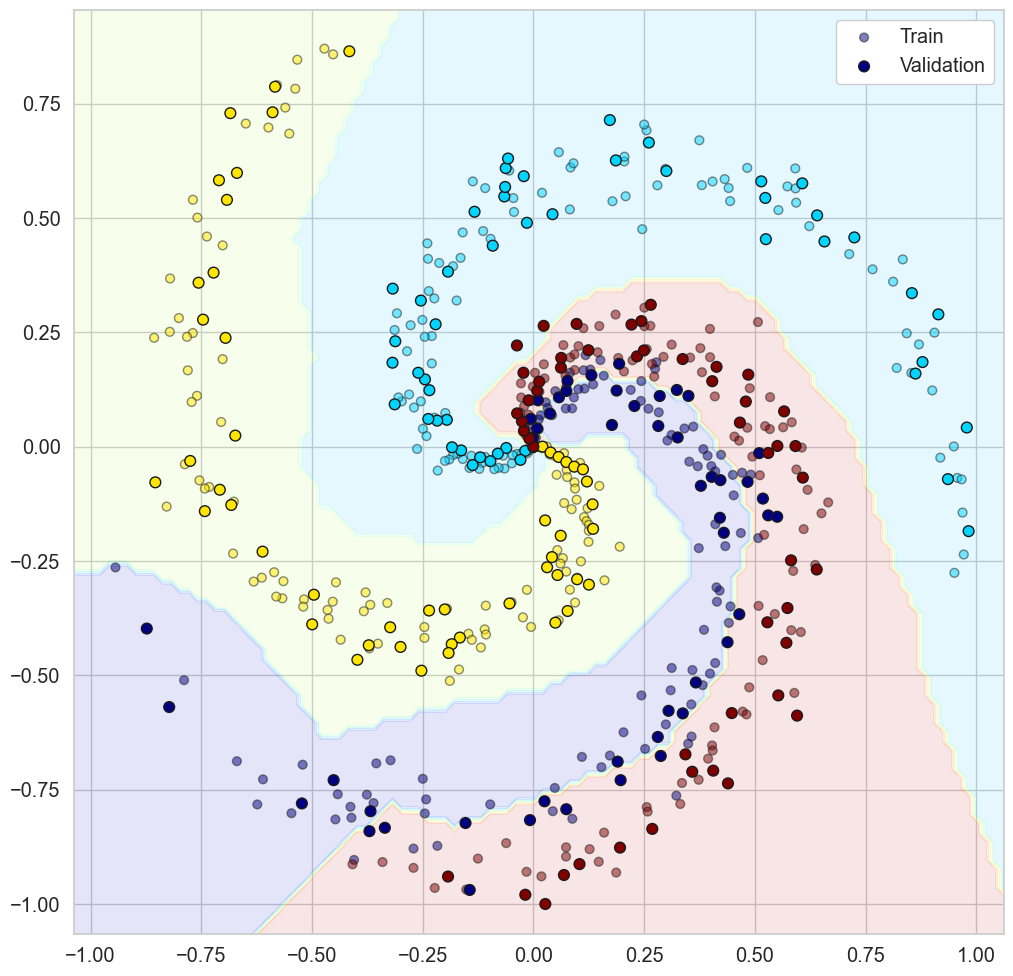

In [88]:
plot_model_pytorch(model_mlp_3, X_train, y_train, (X_valid, y_valid))

Final metrics

In [89]:
print("Train accuracy: {:.1f}%".format(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor)[1].item()))
print("Valid accuracy: {:.1f}%".format(evaluate(model_mlp_3, metrics_func, X_valid_tensor, y_valid_tensor)[1].item()))

Train accuracy: 91.0%
Valid accuracy: 85.0%


# Questions

1. Is data normalization needed here? If you add it, will the quality change? Why / why not?

In the dataset synthesized by us, the data are in a rather narrow range [-1; 1], so data normalization should not significantly affect the result. However, data normalization will not be superfluous

2. How will the result change if all intermediate ReLU activation functions are removed from the MLP-3 model?

In the absence of activation functions, the result of the neural network model became similar to the result of the logistic regression model. All surfaces of the class section became linear, which categorically lowered the quality of the model

3. What happens if you increase the MLP-3 learning rate by 10 times? Reduce it by 10 times?

With an increase in the learning rate, the accuracy of the model greatly increased, highlighting all the data in one class.
The same thing happened when the learning rate was reduced by ten times.

4. Попробуйте решить ту же самую задачу, но чтобы теперь в данных было 4 класса. Как выглядят результаты и какое качество получается?

With an increase in the number of classes, the accuracy of all models decreased by +- 10%